# 1: Import required packages & functions <a class="anchor" id="chapter1"></a>

In [1]:
# clear all variables
for i in list(globals().keys()):
    if(i[0] != '_'):
        exec('del {}'.format(i))

#suppress future warnings -- not really a good idea 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
        
# suppress future warnings -- not really a good idea 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd
import csv
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf') # uses vector figures in pdf exports
plt.style.use('seaborn-pastel')

# create a folder
def create_folder(folder):
    import os     
    try: 
        os.mkdir(folder) 
    except FileExistsError:
        print("Directory [ %s ] already exists"%folder)

#create folder to store results
create_folder('CFAS and ADNI')
create_folder('CFAS and ADNI/data')
create_folder('CFAS and ADNI/figure')

Directory [ CFAS and ADNI ] already exists
Directory [ CFAS and ADNI/data ] already exists
Directory [ CFAS and ADNI/figure ] already exists


# 2: CFAS and ADNI Combined Data <a class="anchor" id="chapter2"></a>

In [2]:
# extract dataset
cfas_combined = pd.read_csv(r'CFAS and ADNI/data/cfas_combined_numeric_Binary_Remove(MCI).csv',header = 0)

In [3]:
# extract dataset
adni_combined = pd.read_csv(r'CFAS and ADNI/data/adni_combined_numeric_Binary_Remove(MCI).csv',header = 0)

# ADNI & CFAS Feature-Feature Correlation Ranking

In [4]:
cfas_df = pd.DataFrame(cfas_combined).copy()
cfas_df.drop(['ID'], inplace=True, axis=1)
cfas_df.dropna(subset=['diagnostic'], inplace=True)
cfas_df.reset_index(drop=True, inplace=True)

adni_df = pd.DataFrame(adni_combined).copy()

## Impute Missing Values

In [5]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

def imputing(df):
    categorical = ['sex', 'braak stage','education',
           'Thal phase', 'brain fresh/fixed weight','cortical atrophy', 'hippocampus atrophy',
            'atherosclerosis','haemorrhage', 'pick disease', 'neocortical neuritic plaques',
           'neuronal loss in substantia nigra', 'argyrophilic grains disease',
           'cerebral amyloid angiopathy', 'infarcts and lacunes','arteriolar sclerosis', 
            'diffuse plaques']


    numerical = ['age', 'brain weight', 'post mortem interval']

    imputed = pd.DataFrame(df[numerical]).copy()
    scaler = MinMaxScaler()
    imputed[numerical] = scaler.fit_transform(imputed[numerical])
    imputed = pd.concat([imputed, df[categorical]], axis=1)
    imputed

    '''
    impute missing values
    '''
    imputed[categorical] = imputed[categorical].apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index))

    #create a model to impute numerical features
    imp_num = IterativeImputer(estimator=RandomForestRegressor(),
                               initial_strategy='mean',
                               max_iter=5, random_state=205)

    #create a model to impute catergorical features
    imp_cat = IterativeImputer(estimator=RandomForestClassifier(), 
                               initial_strategy='most_frequent',
                               max_iter=5, random_state=205)

    # fit_transform to impute both numerica and categorical values
    imputed[numerical] = imp_num.fit_transform(imputed[numerical])
    imputed[categorical] = imp_cat.fit_transform(imputed[categorical])

    return imputed


cfas_df = pd.DataFrame(cfas_combined).copy()
cfas_df.drop(['ID'], inplace=True, axis=1)
cfas_df.dropna(subset=['diagnostic'], inplace=True)

cfas_df.reset_index(drop=True, inplace=True)

adni_df = pd.DataFrame(adni_combined).copy()

# call imputing() function
cfas_imputed = imputing(cfas_df)
adni_imputed = imputing(adni_df)

create_folder('Impute')
cfas_imputed.to_csv(r'Impute/cfas_imputed.csv',mode = 'w',index=False)
adni_imputed.to_csv(r'Impute/adni_imputed.csv',mode = 'w',index=False)



Directory [ Impute ] already exists


## Multiple Linear Regression (R-Squared)

In [6]:
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

def ols_r2(data):
    # remove spaces in columns name.
    data.columns = data.columns.str.replace(' ','_')
    data.columns = data.columns.str.replace('/','_')
    features = data.columns

#     numerical = ['age', 'brain_weight', 'post_mortem_interval']
    
    scaler = MinMaxScaler()
#     data[numerical] = scaler.fit_transform(data[numerical])

    r2scores = []
    adjustedr2 = []
    residual = []
    print("Dependent Variable:")

    for each in features:
#         print(each)
        dataset = pd.DataFrame(data).copy()

        #get data and target
        y = np.ravel(dataset[each])
        dataset = dataset.drop(columns=[each])

        feas_list = ' + '.join([str(n) for n in dataset.columns.astype(str)])
        res = smf.ols(formula="%s"%each+"~ %s"%feas_list, data=data).fit()
    #     print(res.summary())
    #     print(res.rsquared)
    #     print(res.rsquared_adj)

        r2scores.append(res.rsquared)
        adjustedr2.append(res.rsquared_adj)

    print()
    scoring_df = pd.DataFrame(np.column_stack((r2scores, adjustedr2)), columns=['R2', 'Adj_R2'])
    scoring_df['Features'] = data.columns
    # scoring_df['features'] = range(1, 10)
    scoring_df = scoring_df.sort_values(by=['R2'], ascending=False).reset_index(drop=True)
    
    return scoring_df



features_no_demo = ['neocortical neuritic plaques', 'braak stage', 'Thal phase',
       'diffuse plaques', 'cerebral amyloid angiopathy', 'hippocampus atrophy',
       'arteriolar sclerosis', 'neuronal loss in substantia nigra',
       'atherosclerosis', 'cortical atrophy', 'haemorrhage',
       'infarcts and lacunes', 'argyrophilic grains disease']

cfas_ols_r2 = pd.DataFrame(cfas_imputed[features_no_demo]).copy()
# cfas_ols_r2 = cfas_ols_r2.drop(columns=['diagnostic'])
# cfas_ols_r2 = cfas_ols_r2.drop(columns=['pick disease', 'argyrophilic grains disease'])
adni_ols_r2 = pd.DataFrame(adni_imputed[features_no_demo]).copy()
# adni_ols_r2 = adni_ols_r2.drop(columns=['diagnostic'])
# adni_ols_r2 = adni_ols_r2.drop(columns=['pick disease', 'argyrophilic grains disease'])


cfas_mlr_result = ols_r2(cfas_ols_r2)
# cfas_mlr_result = cfas_mlr_result.drop(columns=['Adj_R2'])

adni_mlr_result = ols_r2(adni_ols_r2)
# adni_mlr_result = adni_mlr_result.drop(columns=['Adj_R2'])


cfas_mlr_result.to_csv('CFAS and ADNI/data/cfas_mlr_result.csv',index=False)
adni_mlr_result.to_csv('CFAS and ADNI/data/adni_mlr_result.csv',index=False)

Dependent Variable:

Dependent Variable:



In [7]:
cfas_mlr_result

,R2,Adj_R2,Features
0,0.652799,0.627394,Thal_phase
1,0.643129,0.617017,neocortical_neuritic_plaques
2,0.615900,0.587795,braak_stage
3,0.446770,0.406290,cerebral_amyloid_angiopathy
4,0.427773,0.385903,infarcts_and_lacunes
5,0.421785,0.379477,haemorrhage
6,0.352305,0.304912,diffuse_plaques
7,0.254078,0.199499,hippocampus_atrophy
8,0.165703,0.104657,neuronal_loss_in_substantia_nigra
9,0.157086,0.095410,cortical_atrophy


### CFAS correlations without demographics

In [8]:
# compute correlations
adni_corr = pd.DataFrame(adni_combined).copy()
adni_corr.drop(['ID', 'sex','education','age','brain weight','brain fresh/fixed weight',
                'post mortem interval', 'pick disease', 'diagnostic'],axis=1, inplace=True)

cfas_corr = pd.DataFrame(cfas_combined).copy()
cfas_corr.drop(['ID', 'sex','education','age','brain weight','brain fresh/fixed weight',
                'post mortem interval', 'pick disease', 'diagnostic'],axis=1, inplace=True)

In [9]:
adni_corr

,braak stage,Thal phase,cortical atrophy,hippocampus atrophy,atherosclerosis,haemorrhage,neuronal loss in substantia nigra,argyrophilic grains disease,cerebral amyloid angiopathy,infarcts and lacunes,arteriolar sclerosis,neocortical neuritic plaques,diffuse plaques
0,1,1,1.0,2.0,2.0,0,1.0,1.0,0,0,2,0,1
1,2,1,1.0,1.0,1.0,0,1.0,0.0,1,0,1,1,1
2,2,3,1.0,1.0,1.0,0,2.0,1.0,0,0,1,0,1
3,6,5,NaN,NaN,NaN,1,1.0,NaN,2,0,0,3,3
4,5,5,2.0,1.0,1.0,0,1.0,0.0,3,0,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,6,5,2.0,2.0,3.0,0,1.0,0.0,3,0,1,3,3
66,4,5,NaN,NaN,NaN,0,2.0,NaN,1,1,2,1,3
67,1,2,1.0,0.0,0.0,0,0.0,0.0,1,0,1,0,3
68,6,5,2.0,2.0,1.0,0,1.0,NaN,1,0,1,3,3


### Plot Feature-Feature correlations & R-Squared

In [10]:
cfas_features_percentage = pd.read_csv(r'Ranking/cfas_features_percentage_sorted.csv',header = 0)
adni_features_percentage = pd.read_csv(r'Ranking/adni_features_percentage_sorted.csv',header = 0)

cfas_features_percentage.Features = cfas_features_percentage.Features.str.replace('/',' ')
adni_features_percentage.Features = adni_features_percentage.Features.str.replace('/',' ')
cfas_mlr_result.Features = cfas_mlr_result.Features.str.replace('_',' ')
adni_mlr_result.Features = adni_mlr_result.Features.str.replace('_',' ')

Text(0.5, 1.0, 'CFAS')

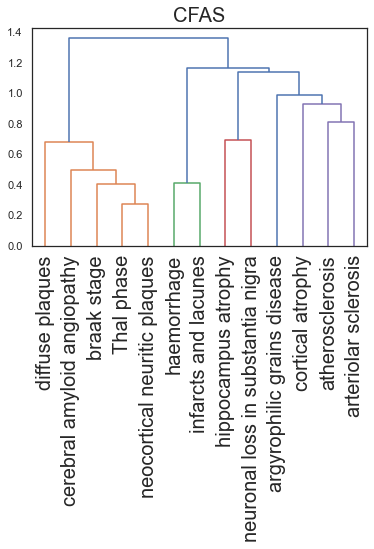

In [11]:
# compute correlations
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
# corr = spearmanr(X).correlation


corr1 = cfas_corr.corr('spearman')
corr1 = corr1.to_numpy()


# Ensure the correlation matrix is symmetric
corr1 = (corr1 + corr1.T) / 2
np.fill_diagonal(corr1, 1)
corr1 = np.nan_to_num(corr1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr1)

sns.set_theme(style="white")

fig, ax1 = plt.subplots(figsize=(6, 4))
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(dist_linkage, labels=cfas_corr.columns.tolist(), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax1.tick_params(axis='x', which='major', labelsize=20)
ax1.set_title('CFAS', fontsize=20)


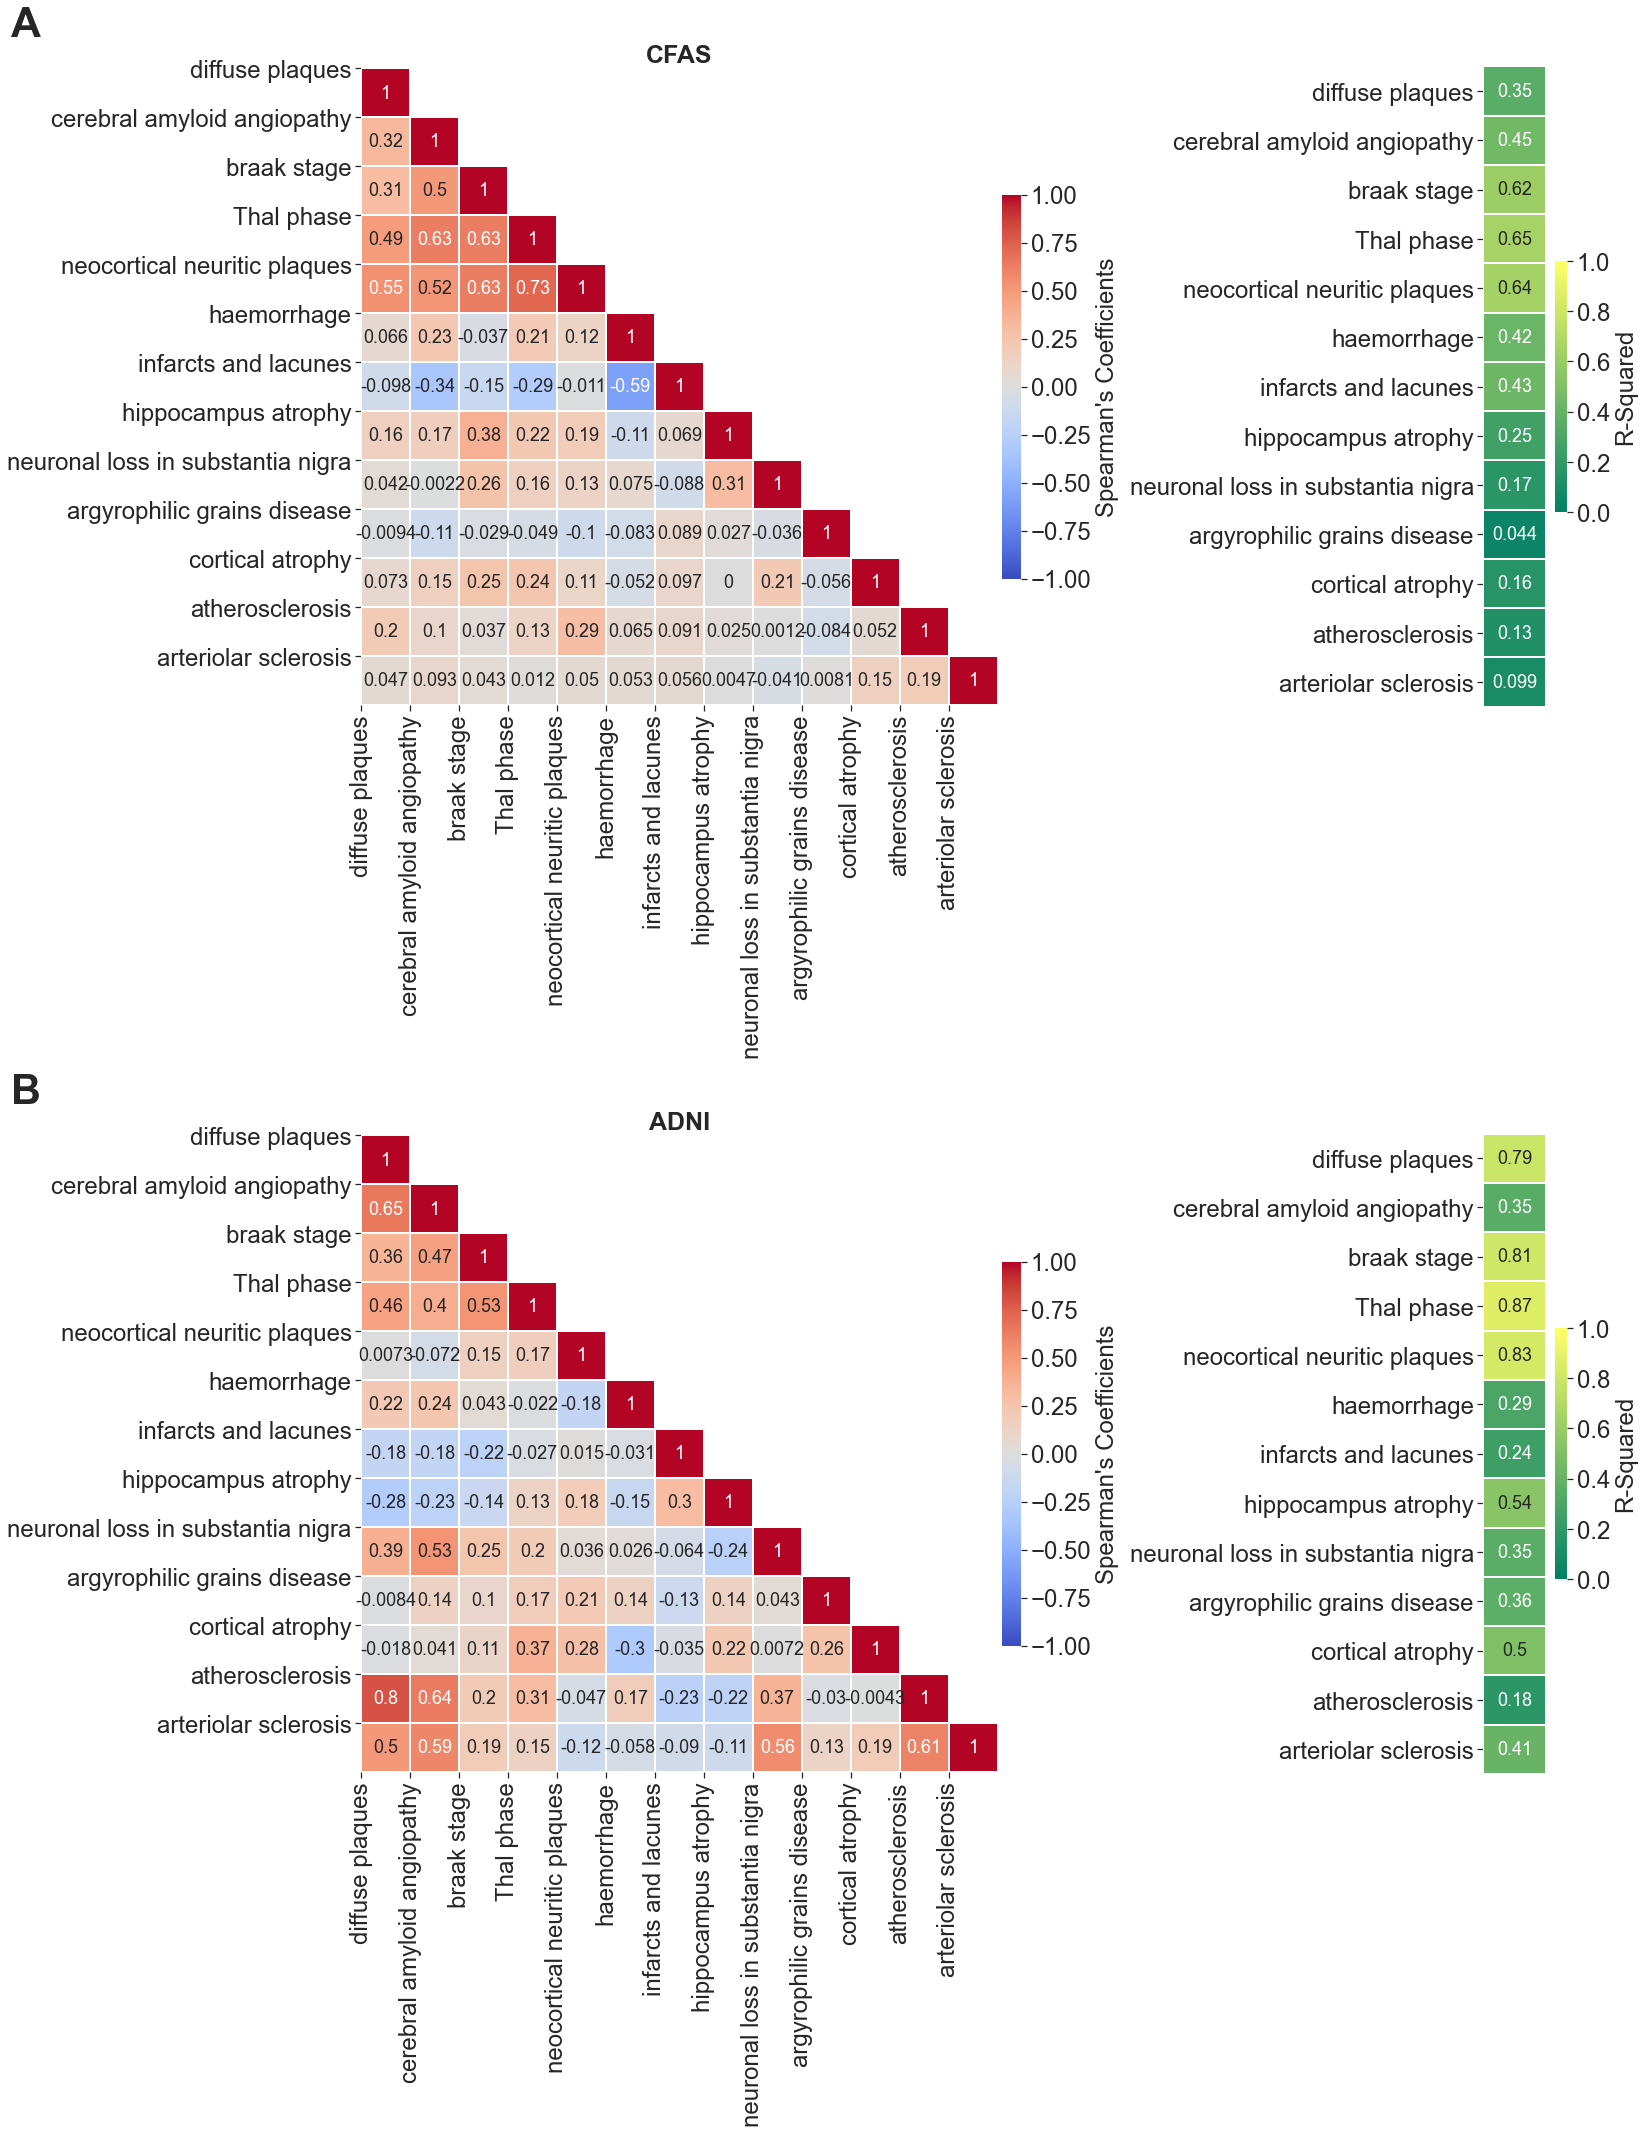

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# corr1 = cfas_corr.corr('spearman')
corr2 = adni_corr.corr('spearman')


# mask2 = np.zeros_like(corr2, dtype=np.bool)
mask1 = np.triu(np.ones_like(corr1, dtype=bool))
mask1[np.triu_indices_from(mask1)] = True
# show the ones values in the diagonal
np.fill_diagonal(mask1, False)

# mask1 = np.zeros_like(corr1, dtype=np.bool)
mask2 = np.triu(np.ones_like(corr2, dtype=bool))
mask2[np.triu_indices_from(mask2)] = True
# show the ones values in the diagonal
np.fill_diagonal(mask2, False)


cfas_r2 = cfas_mlr_result.set_index('Features')
cfas_r2 = cfas_r2.reindex(index=dendro["ivl"])
cfas_r2 = cfas_r2.reset_index()
cfas_r2

adni_r2 = adni_mlr_result.set_index('Features')
adni_r2 = adni_r2.reindex(index=dendro["ivl"])
adni_r2 = adni_r2.reset_index()
adni_r2



sns.set_theme(style="white")
size = 24
plt.rc('font', size=size)          # controls default text sizes
plt.rc('axes', titlesize=size)     # fontsize of the axes title
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plt.rc('legend', fontsize=size)    # legend fontsize
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels

# fig= plt.subplots(figsize=(20,20))
# fig, axn = plt.subplots(1, 2,figsize=(20,15), gridspec_kw={'height_ratios': [1, 20]})
# cbar_ax = fig.add_axes([.5, .1, .02, .1])
#define subplots
fig, ax = plt.subplots(2, 2, figsize=(20,30), gridspec_kw={'width_ratios': [9, 1]})
# fig.tight_layout()

plt.subplots_adjust(wspace=0.1)

ax1 = plt.subplot(2,2,1)
sns.heatmap(corr1[dendro["leaves"], :][:, dendro["leaves"]],
            vmin=-1,vmax=1,mask = mask1,
            cmap='coolwarm', annot=True, square=True, linewidths=.25,
            annot_kws={"fontsize":18}, ax=ax1, cbar=True,
             cbar_kws={"shrink": 0.6, "pad":0.006, 'label': "Spearman's Coefficients"})#, 'orientation': 'horizontal'});
ax1.set_title('CFAS', fontweight='bold', fontsize=25)
ax1.tick_params(right=False, top=False, labelright=False, labeltop=False, labelleft=True, bottom=True, labelbottom=True, left=True)
ax1.set_xticks(dendro_idx)
ax1.set_yticks(dendro_idx)
ax1.set_xticklabels(dendro["ivl"], rotation=90, horizontalalignment='center')
ax1.set_yticklabels(dendro["ivl"], rotation=360)
ax1.text(-0.55, 1.05, 'A', transform=ax1.transAxes, size='xx-large', weight='bold')
plt.subplots_adjust(wspace=0.85, hspace=2.8)

ax3 = plt.subplot(2,2,2)
df = pd.DataFrame(cfas_r2.R2.values, index=cfas_r2.Features)
sns.heatmap(df, annot=True, cmap='summer', ax=ax3, cbar=True, linewidths=.25,
           vmin=0,vmax=1, annot_kws={"fontsize":18},
                cbar_kws={"shrink": 3.5, "pad":0.1, 'label': "R-Squared"})#,'orientation': 'horizontal'})
ax3.tick_params(right=False, top=False, labelright=False, labeltop=False, labelleft=True, labelbottom=False, bottom=False, left=True)
ax3.set_xticklabels("")
plt.xlabel("")
plt.ylabel("")
# plt.subplots_adjust(wspace=0.0, hspace=1)




ax2 = plt.subplot(2,2,3)
sns.heatmap(corr2,
            vmin=-1,vmax=1,mask = mask2, 
            cmap='coolwarm', annot=True, square=True, linewidths=.25, 
            annot_kws={"fontsize":18}, ax=ax2, cbar=True,
            cbar_kws={"shrink": 0.6, "pad":0.006, 'label': "Spearman's Coefficients"}); 
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation=90, horizontalalignment='center')
ax2.set_yticklabels(dendro["ivl"], rotation=0)
ax2.set_title('ADNI', fontweight='bold', fontsize=25)
ax2.tick_params(right=False, top=False, labelright=False, labeltop=False, labelleft=True, bottom=True, labelbottom=True, left=True)
ax2.text(-0.55, 1.05, 'B', transform=ax2.transAxes, size='xx-large', weight='bold')
plt.subplots_adjust(wspace=0.85, hspace=2.8)



ax4 = plt.subplot(2,2,4)
df = pd.DataFrame(adni_r2.R2.values, index=adni_r2.Features)
sns.heatmap(df, annot=True, cmap='summer', ax=ax4, cbar=True, linewidths=.25,
            vmin=0,vmax=1, annot_kws={"fontsize":18},
                cbar_kws={"shrink": 3.5, "pad":0.1, 'label': "R-Squared"})
ax4.tick_params(right=False, top=False, labelright=False, labeltop=False, labelleft=True, labelbottom=False, bottom=False, left=True)
ax4.set_xticklabels("")
plt.xlabel("")
plt.ylabel("")
# plt.subplots_adjust(wspace=0.0, hspace=1)

plt.tight_layout()
plt.savefig('Figures/adni_cfas_R2_heatmap.png',dpi=300, bbox_inches="tight")
plt.savefig('Figures/adni_cfas_R2_heatmap.pdf',dpi=300, bbox_inches="tight")

